# Ant sorting

### General rules
No two objects can exist on the same cell

No two ants can exist on the same cell (not yet the case)

In [2]:
import numpy as np
import random

In [3]:
class Ant:
    """Agent that moves object on the grid"""
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.object = 0
        self.laden = False

    def pickup(self, object):
        self.object = object
        self.laden = True
        
    def drop(self):
        self.object = 0
        self.laden = False
        
    def move(self, ants):
        neighbours = von_neumann_neighbourhood(self.x, self.y)
        # check if any ant in the neighborhood
        for ant in ants:
            if (ant.x, ant.y) in neighbours:
                neighbours.remove((ant.x, ant.y))
        if len(neighbours) >= 1
        self.x, self.y = neighbours[random.randint(0, len(neighbours) - 1)]
        

In [4]:
def von_neumann_neighbourhood(x, y):
    """return coordinates of all cells in the Von Neumann neighbourhood of the input cell"""
    
    neighbours = []
    if x - 1 >= 0:
        neighbours.append((x - 1, y))
    if x + 1 < grid_size:
        neighbours.append((x + 1, y))
    if y - 1 >= 0:
        neighbours.append((x, y - 1))
    if y + 1 < grid_size:
        neighbours.append((x, y + 1))
        
    return neighbours

In [5]:
def dissimilarity(object_o, object_n):
    """calculate dissimilarity between objects"""
    if object_o == object_n:
        dis = 0
    else:
        dis = 1
    return dis

In [6]:
def local_density(x, y, object):
    """calculate local density
        x, y = coordinates of the cell
        object = object the ant is holding"""
    
    neighbourhood = von_neumann_neighbourhood(x, y)
    s2 = len(neighbourhood) + 1
    similarity = 0
    
    for x_n, y_n in neighbourhood:
        similarity += 1 - dissimilarity(object, grid[x_n, y_n])/alpha
        
    return max(0, similarity/s2)

In [7]:
def pickup_probability(local_density):
    """calculate pickup probability"""
    
    return (k1/(k1 + local_density))**2

In [8]:
def drop_probability(local_density):
    """calculate drop probability"""
    
    if local_density < k2:
        probability = 2*local_density
    else:
        probability = 1
        
    return probability

## Parameters

In [9]:
grid_size = 10
ant_density = 0.05
object_density = 0.25
n_object_types = 5
t_total = 10000
k1 = 0.1
k2 = 0.15
alpha = 0.9

In [10]:
def initiate_grid(grid_size, ant_density, object_density, n_object_types):
    """intiate the grid with objects and ants"""
    
    grid = np.zeros((grid_size, grid_size), dtype=int)
    n_ants = int(ant_density*grid_size**2)
    n_objects = int(object_density*grid_size**2)
    
    for object in range(n_objects):
        color = random.randint(1, n_object_types)
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        grid[x, y] = color
        
    ants = []
    for ant in range(n_ants):
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        ants.append(Ant(x, y))
        
    print(f"There are {n_objects} objects and {n_ants} ants on the grid.")    
    return grid, ants

In [11]:
original_grid, ants = initiate_grid(grid_size, ant_density, object_density, n_object_types)

There are 25 objects and 5 ants on the grid.


(-0.5, 9.5, 9.5, -0.5)

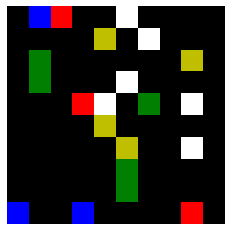

In [12]:
import matplotlib.pyplot as plt
import matplotlib
plt.imshow(original_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']))
plt.axis('off')

## Simulation

In [14]:
#grids = [] !!Grid niet elke timestep opslaan, is meerdere GB

grid = np.copy(original_grid)

for t in range(1, t_total):
    
    for ant in ants:
        
        if (ant.laden == False) & (grid[ant.x, ant.y] != 0):
            p_pickup = pickup_probability(local_density(ant.x, ant.y, grid[ant.x, ant.y]))
            
            if random.random() <= p_pickup:
                ant.pickup(grid[ant.x, ant.y])
                grid[ant.x, ant.y] = 0
                
        elif (ant.laden == True) & (grid[ant.x, ant.y] == 0):
            p_drop = drop_probability(local_density(ant.x, ant.y, ant.object))
            
            if random.random() <= p_drop:
                grid[ant.x, ant.y] = ant.object
                ant.drop()
        
        ant.move()
        #grids.append(np.copy(grid))
        
for ant in ants:
    while ant.laden:
        if grid[ant.x, ant.y] == 0:
            ant.drop()
        else:
            ant.move()

(-0.5, 9.5, 9.5, -0.5)

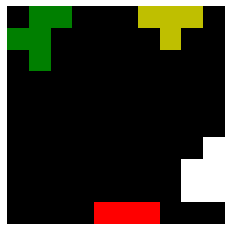

In [15]:
plt.imshow(grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']))
plt.axis('off')

In [16]:
sum(sum(grid == original_grid))

66

# With clusters

In [17]:
class Cluster:
    """cluster object"""
    
    def __init__(self):
        self.x = []
        self.y = []
        self.objects = []
        self.object_type = 0

    def add_object(self, x, y, object):
        self.x.append(x)
        self.y.append(y)
        self.objects.append(object)
        self.object_type = np.mean(self.objects)
        

In [18]:
def calculate_clusters(grid):
    clusters = []
    cluster_grid = np.zeros((grid_size, grid_size), dtype=int)
    
    #iterate over all grid cells
    for x in range(grid_size):
        for y in range(grid_size):
            
            # if it's an object
            if grid[x, y] != 0:

                # if the object is not in a cluster
                if cluster_grid[x, y] == 0:
                
                    # if a neighbour is of the same type and in a cluster, add the object to that cluster
                    for x_n, y_n in von_neumann_neighbourhood(x, y):
                        ds = dissimilarity(grid[x, y], grid[x_n, y_n])
                        if (ds == 0) and (cluster_grid[x_n, y_n] != 0):
                            cluster = clusters[int(cluster_grid[x_n, y_n]) - 1] # cluster grid value is clusters list position +1 (no 0)
                            cluster.add_object(x, y, grid[x, y])
                            cluster_grid[x, y] = cluster_grid[x_n, y_n]
                            break
                                
                    # if no neighbours are in a cluster and the same type, make a cluster
                    if cluster_grid[x, y] == 0:
                        clusters.append(Cluster())
                        clusters[len(clusters) - 1].add_object(x, y, grid[x, y])
                        cluster_grid[x, y] = len(clusters)
                    
    return clusters, cluster_grid

In [19]:
clusters, cluster_grid = calculate_clusters(original_grid)

In [20]:
len(clusters)

19

In [21]:
clusters[0].objects

[3]

(-0.5, 9.5, 9.5, -0.5)

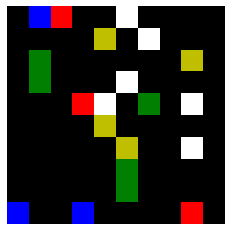

In [22]:
import matplotlib.pyplot as plt
import matplotlib
plt.imshow(original_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']))
plt.axis('off')

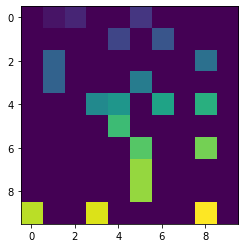

In [23]:
plt.imshow(cluster_grid)

In [24]:
cluster_types = np.zeros((grid_size, grid_size), dtype=int)

for x in range(grid_size):
    for y in range(grid_size):
        if cluster_grid[x, y] != 0:
            cluster_types[x,y] = clusters[int(cluster_grid[x, y]) - 1].objects[0]

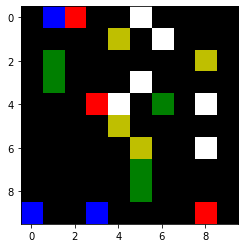

In [25]:
plt.imshow(cluster_types, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']))

In [26]:
original_grid, ants = initiate_grid(grid_size, ant_density, object_density, n_object_types)

There are 25 objects and 5 ants on the grid.


In [27]:
clusters, cluster_grid = calculate_clusters(original_grid)

In [28]:
def Von_Neumann_drop(ant):   
    success = True
    
    #get location of ant
    x, y = ant.x, ant.y
    
    #virtual drop of first object in cluster
    temp_grid = np.copy(grid)
    temp_grid[x, y] = ant.object.objects[0]
    
    #iterative virtual drops of next objects in cluster
    for i in range(1, len(ant.object.objects) - 1):
        
        #get location of all neighbours
        neighbours = von_neumann_neighbourhood(x, y)
        max_s = 0
        max_x = float("nan")
        max_y = float("nan")

        #iterate over neighbours
        for x_n, y_n in neighbours:
            #if cell is empty 
            if grid[x_n, y_n] == 0:
                #calculate local density of next object in cluster
                s = local_density(x_n, y_n, ant.object.objects[i])
                #check if this neighbour is the current best neighbour
                if s > max_s:
                    max_s = s
                    max_x = x_n
                    max_y = y_n
        
        if np.isnan(max_x) != True:
            #virtual drop of object on best neighbour
            temp_grid[max_x, max_y] = ant.object.objects[i]
        
            #"move" to the best neighbour
            x = max_x
            y = max_y
            
        else:
            success = False
            break
            
    return success, temp_grid
        

## Parameters

In [50]:
grid_size = 50
ant_density = 0.05
object_density = 0.25
n_object_types = 5
t_total = 10000
k1 = 0.1
k2 = 0.15
alpha = 0.9

In [51]:
def initiate_grid(grid_size, ant_density, object_density, n_object_types):
    """intiate the grid with objects and ants"""
    
    grid = np.zeros((grid_size, grid_size), dtype=int)
    n_ants = int(ant_density*grid_size**2)
    n_objects = int(object_density*grid_size**2)
    
    for object in range(n_objects):
        color = random.randint(1, n_object_types)
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        grid[x, y] = color
        
    ants = []
    for ant in range(n_ants):
        x = random.randint(0, grid_size - 1)
        y = random.randint(0, grid_size - 1)
        ants.append(Ant(x, y))
        
    print(f"There are {n_objects} objects and {n_ants} ants on the grid.")    
    return grid, ants

In [52]:
original_grid, ants = initiate_grid(grid_size, ant_density, object_density, n_object_types)

There are 625 objects and 125 ants on the grid.


(-0.5, 49.5, 49.5, -0.5)

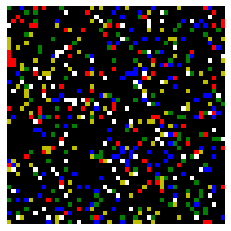

In [53]:
import matplotlib.pyplot as plt
import matplotlib
plt.imshow(original_grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']))
plt.axis('off')

## Simulation

In [ ]:
grids = []
grid = np.copy(original_grid)
clusters, cluster_grid = calculate_clusters(grid)
ant_timer = 0
maxtime = grid_size**2

for t in range(t_total+1):
    
    # keep track of how many timesteps no clusters are dropped
    ant_timer += 1
    
    for ant in ants:
        
        # pickup
        if (ant.laden == False) and (grid[ant.x, ant.y] != 0):            
            # make sure ant doesn't pick up the last cluster of that type to avoid empty grid deadlock
            if sum([grid[ant.x, ant.y] == cluster.objects[0] for cluster in clusters]) != 1:               
                p_pickup = pickup_probability(local_density(ant.x, ant.y, grid[ant.x, ant.y]))            
                if random.random() <= p_pickup:
                    cluster = clusters[int(cluster_grid[ant.x, ant.y]) - 1]
                    ant.pickup(cluster)                
                    # remove cluster & objects from the grids
                    for i in range(len(cluster.x)):
                        grid[cluster.x[i], cluster.y[i]] = 0     
        
        # drop
        elif (ant.laden == True) and (grid[ant.x, ant.y] == 0):
            p_drop = drop_probability(local_density(ant.x, ant.y, ant.object.object_type))        
            if random.random() <= p_drop:                
                success, temp_grid = Von_Neumann_drop(ant)         
                if success:
                    grid = temp_grid
                    ant.drop()
                    ant_timer = 0
        
        # if no clusters have been dropped for too long, force ants to walk around until they drop their clusters
        # to avoid surrounded cluster deadlock (takes very long)
#        if ant_timer == maxtime:     
#            for ant in ants:
#                if ant.laden:
#                    success = False
#                    while not success:
#                        if grid[ant.x, ant.y] == 0:
#                            success, temp_grid = Von_Neumann_drop(ant)
#                        else:
#                            ant.move()
#                    grid = temp_grid
#                    ant.drop()
#                    ant_timer = 0
        
        ant.move()
        # merge adjacent clusters of same type
        clusters, cluster_grid = calculate_clusters(grid)
    
    if t % 1000 == 0:
        grids.append(np.copy(grid))

# force the ants to drop at the end of the simulation
for ant in ants:
    if ant.laden:
        success = False
        while not success:
            if grid[ant.x, ant.y] == 0:
                success, temp_grid = Von_Neumann_drop(ant)
            else:
                ant.move()
        grid = temp_grid
        ant.drop()

In [ ]:
plt.imshow(grid, cmap = matplotlib.colors.ListedColormap(['k', 'r', 'y', 'b', 'w', 'g']))
plt.axis('off')

## Continuous variables

**Functions**